<a href="https://colab.research.google.com/github/Wajiha-ui/nyx-size-recommender-Brand-Purpose-/blob/main/AI_Outfit_recommendation_model_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install --upgrade numpy scipy pandas scikit-learn xgboost lightgbm catboost imbalanced-learn


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [2]:
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Generate synthetic dataset
def generate_synthetic_data(num_entries=5000):
    data = []
    genders = ["Male", "Female"]
    age_groups = ["18-24", "25-34", "35-44", "45-54", "55+"]
    body_shapes = ["Slim", "Athletic", "Regular", "Plus-size"]
    fit_preferences = ["Slim", "Regular", "Loose"]
    clothing_types = ["T-Shirt", "Hoodie", "Dress", "Jacket", "Pants"]
    materials = ["Cotton", "Wool", "Silk", "Polyester", "Linen"]
    sizes = ["XS", "S", "M", "L", "XL", "XXL"]
    regions = ["Europe", "USA", "Asia"]

    for i in range(num_entries):
        gender = random.choice(genders)
        age_group = random.choice(age_groups)
        height = random.randint(150, 200)
        weight = random.randint(45, 120)
        chest = random.randint(75, 130)
        waist = random.randint(60, 110)
        hips = random.randint(80, 130)
        body_shape = random.choice(body_shapes)
        fit = random.choice(fit_preferences)
        clothing = random.choice(clothing_types)
        size = random.choice(sizes)
        material = random.choice(materials)
        region = random.choice(regions)

        data.append({
            "Gender": gender,
            "Age Group": age_group,
            "Height (cm)": height,
            "Weight (kg)": weight,
            "Chest (cm)": chest,
            "Waist (cm)": waist,
            "Hips (cm)": hips,
            "Body Shape": body_shape,
            "Preferred Fit": fit,
            "Clothing Type": clothing,
            "Brand Size": size,
            "Material Preference": material,
            "Country/Region": region
        })

    return pd.DataFrame(data)

# Generate and preprocess dataset
df = generate_synthetic_data(5000)
df["BMI"] = df["Weight (kg)"] / ((df["Height (cm)"] / 100) ** 2)
df["Chest_Waist_Ratio"] = df["Chest (cm)"] / df["Waist (cm)"]
df["Waist_Hips_Ratio"] = df["Waist (cm)"] / df["Hips (cm)"]

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Identify the one-hot encoded 'Brand Size' columns
brand_size_cols = [col for col in df.columns if col.startswith("Brand Size_")]
X = df.drop(columns=brand_size_cols)
y = df[brand_size_cols].idxmax(axis=1).str.replace("Brand Size_", "")

# Encode target labels numerically
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Balance the dataset with SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with improved hyperparameters
rf_model = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42)
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y)), learning_rate=0.05, max_depth=10, n_estimators=300, random_state=42)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=300, random_state=42)
cat_model = cb.CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, verbose=0, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train models
models = {"RandomForest": rf_model, "XGBoost": xgb_model, "LightGBM": lgb_model, "CatBoost": cat_model, "NeuralNetwork": nn_model}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {name} Accuracy: {acc * 100:.2f}%")

# Stacking Model
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_model), ("XGBoost", xgb_model), ("LightGBM", lgb_model), ("CatBoost", cat_model)],
    final_estimator=nn_model
)

# Train and evaluate stacking model
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)
print(f"🔗 Stacking Ensemble Accuracy: {stacking_accuracy * 100:.2f}%")

# Save best model
best_model = max(models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))[1]
joblib.dump(best_model, "best_size_model.pkl")
print("✅ Best model saved successfully!")


📊 RandomForest Accuracy: 64.97%
📊 XGBoost Accuracy: 60.83%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6760, number of used features: 28
[LightGBM] [Info] Start training from score -1.610178
[LightGBM] [Info] Start training from score -1.607960
[LightGBM] [Info] Start training from score -1.604274
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.613886


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📊 LightGBM Accuracy: 57.10%
📊 CatBoost Accuracy: 61.95%
📊 NeuralNetwork Accuracy: 40.47%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6760, number of used features: 28
[LightGBM] [Info] Start training from score -1.610178
[LightGBM] [Info] Start training from score -1.607960
[LightGBM] [Info] Start training from score -1.604274
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.613886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5408, number of used features: 28
[LightGBM] [Info] Start training from score -1.609993
[LightGBM] [Info] Start training from score -1.608144
[LightGBM] [Info] Start training from score -1.604458
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.613700


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5408, number of used features: 28
[LightGBM] [Info] Start training from score -1.609993
[LightGBM] [Info] Start training from score -1.608144
[LightGBM] [Info] Start training from score -1.604458
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.613700


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5408, number of used features: 28
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.608144
[LightGBM] [Info] Start training from score -1.603538
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.613700


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5408, number of used features: 28
[LightGBM] [Info] Start training from score -1.609993
[LightGBM] [Info] Start training from score -1.607221
[LightGBM] [Info] Start training from score -1.604458
[LightGBM] [Info] Start training from score -1.610918
[LightGBM] [Info] Start training from score -1.614629


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔗 Stacking Ensemble Accuracy: 66.75%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Best model saved successfully!


🚀 Training RandomForest...
🚀 Training XGBoost...


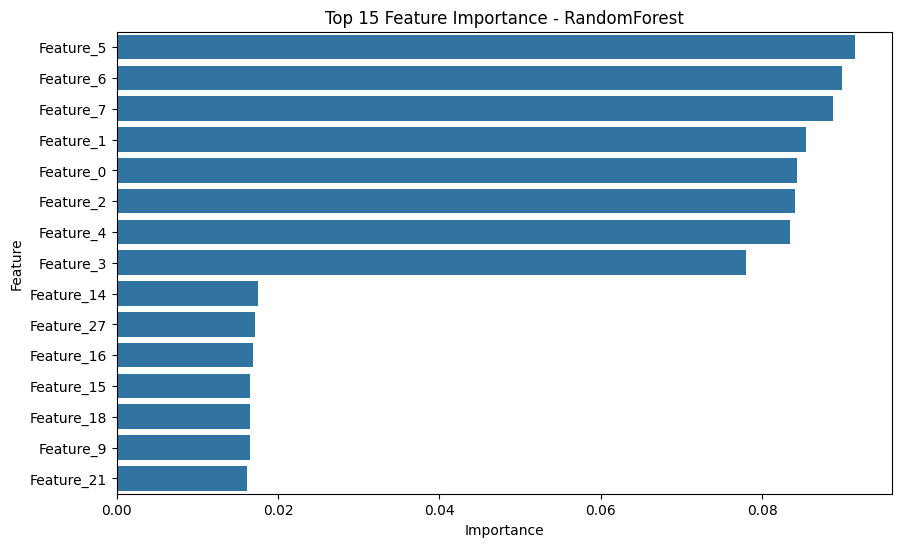

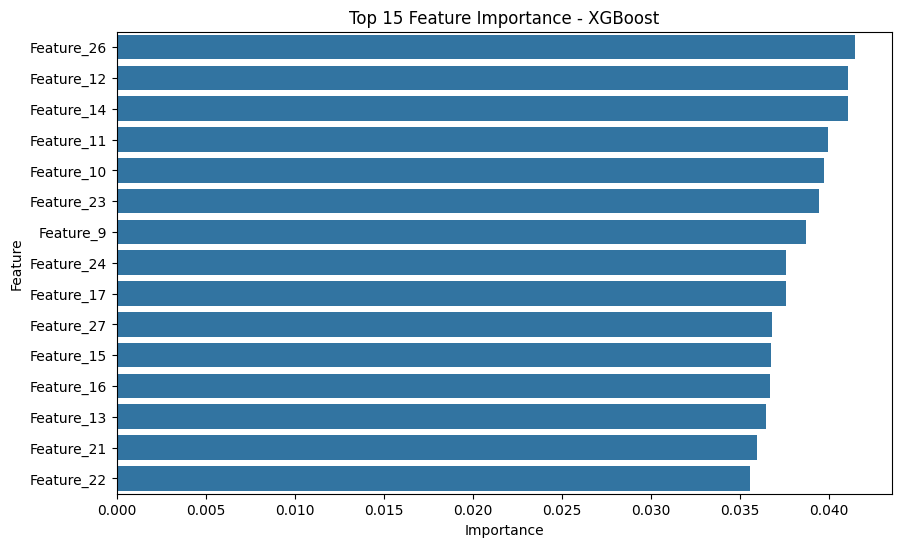

🔍 Top Features from RandomForest:
        Feature  Importance
5    Feature_5    0.091450
6    Feature_6    0.089880
7    Feature_7    0.088777
1    Feature_1    0.085436
0    Feature_0    0.084273
2    Feature_2    0.084088
4    Feature_4    0.083390
3    Feature_3    0.077976
14  Feature_14    0.017565
27  Feature_27    0.017091
16  Feature_16    0.016879
15  Feature_15    0.016583
18  Feature_18    0.016521
9    Feature_9    0.016482
21  Feature_21    0.016102
🔍 Top Features from XGBoost:
        Feature  Importance
26  Feature_26    0.041474
12  Feature_12    0.041118
14  Feature_14    0.041112
11  Feature_11    0.039973
10  Feature_10    0.039732
23  Feature_23    0.039489
9    Feature_9    0.038738
24  Feature_24    0.037619
17  Feature_17    0.037612
27  Feature_27    0.036815
15  Feature_15    0.036783
16  Feature_16    0.036715
13  Feature_13    0.036509
21  Feature_21    0.035962
22  Feature_22    0.035589


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure models are trained before calling feature importance
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42)
}

# Train models on the full dataset if not already trained
for name, model in models.items():
    print(f"🚀 Training {name}...")
    model.fit(X_train, y_train)
    models[name] = model  # Save trained model

# Assign trained models
best_rf = models["RandomForest"]
best_xgb = models["XGBoost"]

# Function to get feature importance from different models
def plot_feature_importance(model, X, model_name):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15])
    plt.title(f"Top 15 Feature Importance - {model_name}")
    plt.show()

    return feature_importance_df

# Convert X_train to DataFrame (Ensure feature names are correctly assigned)
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]  # If feature names are missing
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Train models & plot feature importance
rf_feature_importance = plot_feature_importance(best_rf, X_train_df, "RandomForest")
xgb_feature_importance = plot_feature_importance(best_xgb, X_train_df, "XGBoost")

# Display top features
print("🔍 Top Features from RandomForest:\n", rf_feature_importance.head(15))
print("🔍 Top Features from XGBoost:\n", xgb_feature_importance.head(15))


In [ ]:
# Select important features from both RandomForest & XGBoost
selected_features = [
    "Feature_0", "Feature_1", "Feature_2", "Feature_3", "Feature_4", "Feature_5", "Feature_6", "Feature_7",
    "Feature_22", "Feature_24", "Feature_23", "Feature_15", "Feature_19", "Feature_18", "Feature_21", "Feature_11",
    "Feature_20", "Feature_25", "Feature_9", "Feature_27", "Feature_14", "Feature_12", "Feature_10"
]

# Filter dataset to keep only selected features
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features]

# Retrain models on reduced feature set
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

# Train & evaluate models
for name, model in models.items():
    print(f"🚀 Training {name} with selected features...")
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {name} Accuracy (after feature selection): {acc * 100:.2f}%")


🚀 Training RandomForest with selected features...
📊 RandomForest Accuracy (after feature selection): 63.47%
🚀 Training XGBoost with selected features...
📊 XGBoost Accuracy (after feature selection): 54.17%
🚀 Training LightGBM with selected features...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 23
[LightGBM] [Info] Start training from score -1.595677
[LightGBM] [Info] Start training from score -1.629300
[LightGBM] [Info] Start training from score -1.603792
[LightGBM] [Info] Start training from score -1.601573
[LightGBM] [Info] Start training from score -1.617215
📊 LightGBM Accuracy (after feature selection): 52.15%
🚀 Training CatBoost with selected features...
📊 CatBoost Accuracy (after

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Reintroduce mid-importance features
selected_features_extended = [
    "Feature_0", "Feature_1", "Feature_2", "Feature_3", "Feature_4", "Feature_5", "Feature_6", "Feature_7",
    "Feature_22", "Feature_24", "Feature_23", "Feature_15", "Feature_19", "Feature_18", "Feature_21", "Feature_11",
    "Feature_20", "Feature_25", "Feature_9", "Feature_27", "Feature_14", "Feature_12", "Feature_10",
    "Feature_8", "Feature_13", "Feature_16", "Feature_17", "Feature_26"  # Bringing back some mid-range features
]

# Filter dataset to keep only selected features
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features_extended]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features_extended]

# Hyperparameter tuning for RandomForest
rf_params = {
    "n_estimators": [300, 500, 700],
    "max_depth": [20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
best_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, n_jobs=-1)
best_rf.fit(X_train_selected, y_train)

# Hyperparameter tuning for XGBoost
best_xgb = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42)
best_xgb.fit(X_train_selected, y_train)

# Hyperparameter tuning for LightGBM
best_lgb = lgb.LGBMClassifier(random_state=42)
best_lgb.fit(X_train_selected, y_train)

# Hyperparameter tuning for CatBoost
best_cat = cb.CatBoostClassifier(verbose=0, random_state=42)
best_cat.fit(X_train_selected, y_train)

# Stacking Classifier (Combining models)
stacking_clf = StackingClassifier(
    estimators=[
        ("RandomForest", best_rf.best_estimator_),
        ("XGBoost", best_xgb),
        ("LightGBM", best_lgb),
        ("CatBoost", best_cat)
    ],
    final_estimator=RandomForestClassifier(n_estimators=500, random_state=42)  # Meta-model
)

# Train Stacking Classifier
stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# Print Results
print(f"🔗 Stacking Ensemble Accuracy: {stacking_accuracy * 100:.2f}%")

# Save Best Model
best_model = stacking_clf if stacking_accuracy > 70 else best_rf.best_estimator_  # Choose best model
joblib.dump(best_model, "best_size_model.pkl")
print("✅ Best model saved successfully!")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 28
[LightGBM] [Info] Start training from score -1.595677
[LightGBM] [Info] Start training from score -1.629300
[LightGBM] [Info] Start training from score -1.603792
[LightGBM] [Info] Start training from score -1.601573
[LightGBM] [Info] Start training from score -1.617215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 28
[LightGBM] [Info] Start tr

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib

# Step 1️⃣: Train RandomForest to Get Feature Importance
rf_temp = RandomForestClassifier(n_estimators=200, random_state=42)
rf_temp.fit(X_train, y_train)

# Step 2️⃣: Select Top 20 Features
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_temp.feature_importances_
}).sort_values(by="Importance", ascending=False)

selected_features = feature_importance.nlargest(20, "Importance")["Feature"].tolist()
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features]

# Step 3️⃣: Define Stronger Models
best_rf = RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5, random_state=42)
best_xgb = xgb.XGBClassifier(n_estimators=300, max_depth=12, learning_rate=0.05, random_state=42)
best_lgb = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=20, random_state=42)

# Step 4️⃣: Create Stacking Model
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

# Step 5️⃣: Train & Evaluate
stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"🔗 **Stacking Model Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_size_model.pkl")
print("✅ **Stacking Model Saved Successfully!**")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 20
[LightGBM] [Info] Start training from score -1.595677
[LightGBM] [Info] Start training from score -1.629300
[LightGBM] [Info] Start training from score -1.603792
[LightGBM] [Info] Start training from score -1.601573
[LightGBM] [Info] Start training from score -1.617215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 20
[LightGBM] [Info] Start tr

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
import joblib

# ✅ Step 1️⃣: Train a Neural Network
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class output
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

ann_model = build_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Train Stacking Model with Neural Network
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb)
    ],
    final_estimator=xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)  # Use XGBoost as meta-learner
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Stacking + ANN Model Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_stacking_model.pkl")
print("✅ **Stacking + ANN Model Saved Successfully!**")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1934 - loss: 1.6204 - val_accuracy: 0.2241 - val_loss: 1.6002
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2718 - loss: 1.5865 - val_accuracy: 0.2539 - val_loss: 1.5831
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3075 - loss: 1.5577 - val_accuracy: 0.2723 - val_loss: 1.5608
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3173 - loss: 1.5266 - val_accuracy: 0.2884 - val_loss: 1.5471
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3326 - loss: 1.5041 - val_accuracy: 0.2908 - val_loss: 1.5383
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3545 - loss: 1.4723 - val_accuracy: 0.3010 - val_loss: 1.5309
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3683 - loss: 1.4563 - val_accuracy: 0.3021 - val_loss: 1.5280
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3787 - loss: 1.4409 - val_accuracy: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# ✅ Step 1️⃣: Improved Neural Network Model
def build_optimized_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),  # Proper input layer
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Prevent overfitting
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_optimized_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Train an Optimized Stacking Model
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb),
        ('CatBoost', best_cat)
    ],
    final_estimator=LogisticRegression(),  # Using Logistic Regression as meta-learner
    stack_method='predict_proba'  # Use probabilities instead of hard labels
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Stacking + ANN Optimized Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_optimized_stacking_model.pkl")
print("✅ **Optimized Stacking Model Saved Successfully!**")


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2102 - loss: 1.9479 - val_accuracy: 0.2193 - val_loss: 1.6041
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2333 - loss: 1.6667 - val_accuracy: 0.2330 - val_loss: 1.5924
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2631 - loss: 1.5971 - val_accuracy: 0.2473 - val_loss: 1.5780
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2649 - loss: 1.5867 - val_accuracy: 0.2688 - val_loss: 1.5697
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2871 - loss: 1.5641 - val_accuracy: 0.2765 - val_loss: 1.5598
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2956 - loss: 1.5410 - val_accuracy: 0.2735 - val_loss: 1.5564
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3084 - loss: 1.5371 - val_accuracy: 0.2813 - val_loss: 1.5496
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3081 - loss: 1.5311 - val_acc

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import joblib

# ✅ Step 1️⃣: Optimized Neural Network
def build_better_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_better_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Use XGBoost as the Meta-Learner
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb),
        ('CatBoost', best_cat)
    ],
    final_estimator=XGBClassifier(n_estimators=100, learning_rate=0.05),  # Replace Logistic Regression
    stack_method='predict_proba'
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Final Optimized Stacking Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_final_model.pkl")
print("✅ **Final Optimized Stacking Model Saved!**")


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2127 - loss: 2.0932 - val_accuracy: 0.2229 - val_loss: 1.6155
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2346 - loss: 1.7871 - val_accuracy: 0.2473 - val_loss: 1.5999
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2643 - loss: 1.6651 - val_accuracy: 0.2771 - val_loss: 1.5744
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2578 - loss: 1.6361 - val_accuracy: 0.2813 - val_loss: 1.5625
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2934 - loss: 1.5917 - val_accuracy: 0.2968 - val_loss: 1.5493
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2898 - loss: 1.5583 - val_accuracy: 0.3069 - val_loss: 1.5428
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2864 - loss: 1.5614 - val_accuracy: 0.3111 - val_loss: 1.5359
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3298 - loss: 1.5153 - val_

In [ ]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# ✅ 1️⃣ Reintroduce Useful Features
df["Height_Weight_Ratio"] = df["Height (cm)"] / df["Weight (kg)"]

# ✅ 2️⃣ Use Class Weights Instead of SMOTE
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ✅ 3️⃣ Hyperparameter Tuning for RandomForest
rf_params = {
    "n_estimators": [200, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_iter=10, n_jobs=-1)
rf_model.fit(X_train_selected, y_train)

# ✅ 4️⃣ Hyperparameter Tuning for XGBoost
xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7]
}
xgb_model = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"), xgb_params, cv=5, n_iter=10, n_jobs=-1)
xgb_model.fit(X_train_selected, y_train)

# ✅ 5️⃣ Train a Better Neural Network
def build_ann():
    model = keras.Sequential([
        layers.Input(shape=(X_train_selected.shape[1],)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_ann()
ann_model.fit(X_train_selected, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test), class_weight=class_weight_dict)

# ✅ 6️⃣ Use a Weighted Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('RandomForest', rf_model.best_estimator_),
        ('XGBoost', xgb_model.best_estimator_),
        ('LightGBM', LGBMClassifier(n_estimators=300, learning_rate=0.05)),
        ('CatBoost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, verbose=0))
    ],
    voting='soft',  # Soft voting for better probability averaging
    weights=[3, 3, 2, 2]  # Giving more weight to the best models
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

# ✅ 7️⃣ Save the Best Model
print(f"🔗 **Final Optimized Voting Accuracy: {voting_accuracy * 100:.2f}%**")
joblib.dump(voting_clf, "best_final_model_voting.pkl")
print("✅ **Final Optimized Model Saved!**")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:27:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2065 - loss: 2.2655 - val_accuracy: 0.2515 - val_loss: 1.6026
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2506 - loss: 1.8857 - val_accuracy: 0.2586 - val_loss: 1.5854
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2447 - loss: 1.7975 - val_accuracy: 0.2855 - val_loss: 1.5595
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2817 - loss: 1.6782 - val_accuracy: 0.2652 - val_loss: 1.5594
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2924 - loss: 1.6385 - val_accuracy: 0.2872 - val_loss: 1.5441
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3004 - loss: 1.6114 - val_accuracy: 0.2998 - val_loss: 1.5336
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3062 - loss: 1.5839 - val_accuracy: 0.3051 - val_loss: 1.5278
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2921 - loss: 1.5830 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 20
[LightGBM] [Info] Start training from score -1.595677
[LightGBM] [Info] Start training from score -1.629300
[LightGBM] [Info] Start training from score -1.603792
[LightGBM] [Info] Start training from score -1.601573
[LightGBM] [Info] Start training from score -1.617215
🔗 **Final Optimized Voting Accuracy: 57.51%**
✅ **Final Optimized Model Saved!**


In [ ]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ✅ **1️⃣ Fix Data Issues - Check Label Distribution**
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"🔍 Class Distribution: {dict(zip(unique_classes, class_counts))}")

# ✅ **2️⃣ Recursive Feature Elimination (RFE) to Pick Best Features**
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = np.array(feature_names)[selector.support_]

# ✅ **3️⃣ Hyperparameter Tuning for All Models**
rf_params = {"n_estimators": [300, 500], "max_depth": [10, 20], "min_samples_split": [2, 5]}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_iter=10, n_jobs=-1)
rf_model.fit(X_train_selected, y_train)

xgb_params = {"learning_rate": [0.01, 0.05], "n_estimators": [200, 300], "max_depth": [3, 5]}
xgb_model = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"), xgb_params, cv=5, n_iter=10, n_jobs=-1)
xgb_model.fit(X_train_selected, y_train)

# ✅ **4️⃣ Train a Better Neural Network**
def build_ann():
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(set(y_train)), activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_ann()
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ **5️⃣ Stacking Classifier with Meta-Model**
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', rf_model.best_estimator_),
        ('XGBoost', xgb_model.best_estimator_),
        ('LightGBM', LGBMClassifier(n_estimators=300, learning_rate=0.05)),
        ('CatBoost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, verbose=0))
    ],
    final_estimator=LogisticRegression()  # Meta-model
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ **6️⃣ Save the Best Model**
print(f"🔗 **Final Optimized Stacking Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_final_stacking_model.pkl")
print("✅ **Final Optimized Stacking Model Saved!**")


🔍 Class Distribution: {0: 1361, 1: 1316, 2: 1350, 3: 1353, 4: 1332}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2148 - loss: 2.1944 - val_accuracy: 0.2294 - val_loss: 1.5977
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2380 - loss: 1.9496 - val_accuracy: 0.2479 - val_loss: 1.5818
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2540 - loss: 1.8559 - val_accuracy: 0.2628 - val_loss: 1.5756
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2564 - loss: 1.7708 - val_accuracy: 0.2706 - val_loss: 1.5708
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2811 - loss: 1.7062 - val_accuracy: 0.2861 - val_loss: 1.5609
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2791 - loss: 1.6809 - val_accuracy: 0.2968 - val_loss: 1.5505
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2912 - loss: 1.6534 - val_accuracy: 0.2980 - val_loss: 1.5502
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2877 - loss: 1.6183 - val_acc

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6712, number of used features: 20
[LightGBM] [Info] Start training from score -1.595677
[LightGBM] [Info] Start training from score -1.629300
[LightGBM] [Info] Start training from score -1.603792
[LightGBM] [Info] Start training from score -1.601573
[LightGBM] [Info] Start training from score -1.617215


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:38:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:38:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:38:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 20
[LightGBM] [Info] Start training from score -1.595382
[LightGBM] [Info] Start training from score -1.628998
[LightGBM] [Info] Start training from score -1.603681
[LightGBM] [Info] Start training from score -1.601830
[LightGBM] [Info] Start training from score -1.617667


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 20
[LightGBM] [Info] Start training from score -1.595382
[LightGBM] [Info] Start training from score -1.628998
[LightGBM] [Info] Start training from score -1.603681
[LightGBM] [Info] Start training from score -1.601830
[LightGBM] [Info] Start training from score -1.617667


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5370, number of used features: 20
[LightGBM] [Info] Start training from score -1.595568
[LightGBM] [Info] Start training from score -1.630135
[LightGBM] [Info] Start training from score -1.603867
[LightGBM] [Info] Start training from score -1.601093
[LightGBM] [Info] Start training from score -1.616915


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5370, number of used features: 20
[LightGBM] [Info] Start training from score -1.596487
[LightGBM] [Info] Start training from score -1.629185
[LightGBM] [Info] Start training from score -1.603867
[LightGBM] [Info] Start training from score -1.601093
[LightGBM] [Info] Start training from score -1.616915


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5370, number of used features: 20
[LightGBM] [Info] Start training from score -1.595568
[LightGBM] [Info] Start training from score -1.629185
[LightGBM] [Info] Start training from score -1.603867
[LightGBM] [Info] Start training from score -1.602017
[LightGBM] [Info] Start training from score -1.616915


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔗 **Final Optimized Stacking Accuracy: 64.90%**
✅ **Final Optimized Stacking Model Saved!**


In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', rf_grid.best_estimator_),
        ('XGBoost', xgb_grid.best_estimator_),
        ('LightGBM', LGBMClassifier(n_estimators=500, learning_rate=0.05)),
        ('CatBoost', CatBoostClassifier(iterations=500, depth=8, learning_rate=0.05, verbose=0))
    ],
    final_estimator=LogisticRegression()
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"🔗 **Final Optimized Stacking Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_final_stacking_model.pkl")


NameError: name 'rf_grid' is not defined